In [8]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA


from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE




### Import Data

In [9]:
# Load SP500 and US macroeconomic data from CSV files
data = pd.read_csv('./data/SP500_data/GOOGL.csv', parse_dates=['Date'])
macro_data = pd.read_csv('./data/SP500_data/US_macroeconomics.csv', parse_dates=['date'])

# Merge datasets on the date field
merged_data = pd.merge(data, macro_data, left_on='Date', right_on='date', how='outer')

# Handle missing values: forward fill then backward fill to cover all gaps
merged_data.interpolate(method='ffill', inplace=True)
merged_data.interpolate(method='bfill', inplace=True)

# Drop the extra date column to avoid duplication
merged_data.drop(columns=['date'], inplace=True)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Select numerical features for scaling
numerical_features = ['Close', 'Volume', 'CPI', 'Mortgage_rate', 'Unemp_rate', 'NASDAQ', 'disposable_income', 'Personal_consumption_expenditure', 'personal_savings']
merged_data[numerical_features] = scaler.fit_transform(merged_data[numerical_features])

# Ensure all other non-numeric columns are excluded from the feature set
features = numerical_features  # This ensures only the scaled numeric features are used

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(merged_data[numerical_features].drop('Close', axis=1))

# Convert X_pca back to DataFrame for easier handling (optional, for clarity)
X_pca_df = pd.DataFrame(X_pca)

target_data = merged_data['Close']


def create_sequences(features, target, sequence_length=10):
    xs, ys = [], []
    for i in range(len(features) - sequence_length):
        x = features.iloc[i:(i + sequence_length)].values
        y = target.iloc[i + sequence_length]  # Directly use the target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences using the PCA-transformed data and the separate target variable
X, y = create_sequences(X_pca_df, target_data)


# Print the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for each Principal Component:")
for i, variance in enumerate(explained_variance_ratio):
    print(f"Component {i+1}: {variance:.4f}")


Explained Variance Ratio for each Principal Component:
Component 1: 0.6596
Component 2: 0.1942
Component 3: 0.0818
Component 4: 0.0341


In [10]:
def create_sequences(data, sequence_length=10):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values
        y = data.iloc[i + sequence_length]['Close']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(merged_data[features])

# Define split ratios
train_ratio = 0.7  # Adjusted to leave some data for testing
test_ratio = 0.3   # Adjusted accordingly

# Calculate indices for splitting
train_end = int(len(X) * train_ratio)
test_start = train_end  # Start of test data is the end of train data

# Split the data
X_train, y_train = X[:train_end], y[:train_end]
X_test, y_test = X[test_start:], y[test_start:]

# Display the shapes of the datasets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (3347, 10, 9), (3347,)
Test set shape: (1435, 10, 9), (1435,)


In [11]:
def create_cnn_model(input_shape):
    """
    Function to create a Convolutional Neural Network (CNN) model that uses macroeconomic data
    and other properties to predict Google's stock price.
    
    Parameters:
    - input_shape (tuple): The shape of the input data (time_steps, features).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Try Dropout
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model



from keras.layers import Input, Dense, LSTM, Dropout, Reshape
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from imblearn.over_sampling import SMOTE

def build_generator():
    input = Input(shape=(100,))
    x = Dense(120)(input)
    x = Reshape((10, 12))(x)
    x = LSTM(50, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(10 * 9, activation='linear')(x)
    x = Reshape((10, 9))(x)  # Reshape the final output to (10, 9)
    return Model(input, x)

def build_discriminator():
    input = Input(shape=(10, 9))
    x = LSTM(50, return_sequences=True)(input)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan_input = Input(shape=(100,))
fake_data = generator(gan_input)
discriminator.trainable = False
validity = discriminator(fake_data)
gan = Model(gan_input, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()

def train_gan(generator, discriminator, gan, X_train, epochs=100, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_data = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)
        print(f"Epoch: {epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

def generate_synthetic_data(generator, n_samples=1000):
    noise = np.random.normal(0, 1, (n_samples, 100))
    return generator.predict(noise)

def generate_synthetic_data_with_smote(X, n_samples=1000):
    n_features = X.shape[1] * X.shape[2]
    X_flat = X.reshape(-1, n_features)
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, _ = smote.fit_resample(X_flat, [0] * len(X_flat))
    return X_resampled.reshape(-1, X.shape[1], X.shape[2])

synthetic_data = generate_synthetic_data(generator, n_samples=1000)
print("Synthetic Data Generated:", synthetic_data.shape)


In [29]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, Dropout, Reshape
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Define a placeholder for the preprocess_data function
def preprocess_data(X):
    # Assuming preprocessing involves normalization
    scaler = MinMaxScaler()
    return scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# GAN setup
def build_generator():
    input = Input(shape=(100,))
    x = Dense(120)(input)
    x = Reshape((10, 12))(x)
    x = LSTM(50, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(10 * 4, activation='linear')(x)
    x = Reshape((10, 4))(x)
    return Model(input, x)

def build_discriminator():
    input = Input(shape=(10, 4))
    x = LSTM(50, return_sequences=True)(input)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

generator = build_generator()
discriminator = build_discriminator()

# Make discriminator trainable for standalone training
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Assemble GAN
gan_input = Input(shape=(100,))
fake_data = generator(gan_input)
discriminator.trainable = False  # Ensure discriminator is not trainable when training GAN
validity = discriminator(fake_data)
gan = Model(gan_input, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

def train_gan(generator, discriminator, gan, X_train, y_train, epochs=100, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_data = generator.predict(noise)

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)

        print(f"Epoch: {epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

def generate_synthetic_data(generator, n_samples=1000):
    noise = np.random.normal(0, 1, (n_samples, 100))
    return generator.predict(noise)

def generate_synthetic_data_with_smote(X, n_samples=1000):
    n_features = X.shape[1] * X.shape[2]
    X_flat = X.reshape(-1, n_features)
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, _ = smote.fit_resample(X_flat, [0] * len(X_flat))
    return X_resampled.reshape(-1, X.shape[1], X.shape[2])

def evaluate_data(real_data, synthetic_data):
    n_features = real_data.shape[1] * real_data.shape[2]
    real_data_flat = real_data.reshape(-1, n_features)
    synthetic_data_flat = synthetic_data.reshape(-1, n_features)

    accuracy = accuracy_score(real_data_flat, synthetic_data_flat)
    precision = precision_score(real_data_flat, synthetic_data_flat, average='macro')
    recall = recall_score(real_data_flat, synthetic_data_flat, average='macro')
    f1 = f1_score(real_data_flat, synthetic_data_flat, average='macro')

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

try:
    # Ensure preprocessed data
    X_train_normalized = preprocess_data(X_train)

    # Train the GAN
    train_gan(generator, discriminator, gan, X_train_normalized, y_train, epochs=100, batch_size=32)

    # Generate synthetic data
    synthetic_data = generate_synthetic_data(generator, n_samples=1000)

    # Evaluate synthetic data
    evaluate_data(X_train_normalized, synthetic_data)

    print("Synthetic Data Generated:", synthetic_data.shape)
except Exception as e:
    print("Error:", e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/opt/homebrew/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:77: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0 [D loss: 0.6827753782272339] [G loss: 0.693122923374176]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch: 1 [D loss: 0.6856376528739929] [G loss: 0.6930508613586426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch: 2 [D loss: 0.6852754354476929] [G loss: 0.6929833292961121]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch: 3 [D loss: 0.6853652000427246] [G loss: 0.6928910613059998]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch: 4 [D loss: 0.6856492161750793] [G loss: 0.6927860975265503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch: 5 [D loss: 0.6856096982955933] [G loss: 0.6926233172416687]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch: 6 [D loss: 0.6856563091278076] [G loss: 0.692520022392273]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch: 7 [D loss: 0.685700535774231] [G loss: 0.6923798322677612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch: 8 [D loss: 0.6858254671096802] [G loss: 0.6922739744186401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch: 9 [D loss: 0.6860713958740234] [G loss: 0.69216573238372

In [30]:

sequence_length = 10  # You can adjust this based on your specific time series analysis needs


# Create the CNN model
model = create_cnn_model(input_shape=(sequence_length, len(features)))
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Assuming y_pred is already computed
y_pred = model.predict(synthetic_data)

# Calculate regression metrics
#mse = mean_squared_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)

#print(f"Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R^2 Score: {r2}")

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 10, 128)        │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,937 (656.00 KB)

 Trainable params: 167,937 (656.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv1d_6" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 10, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 10, 4), dtype=float32)
  • training=True
  • mask=None

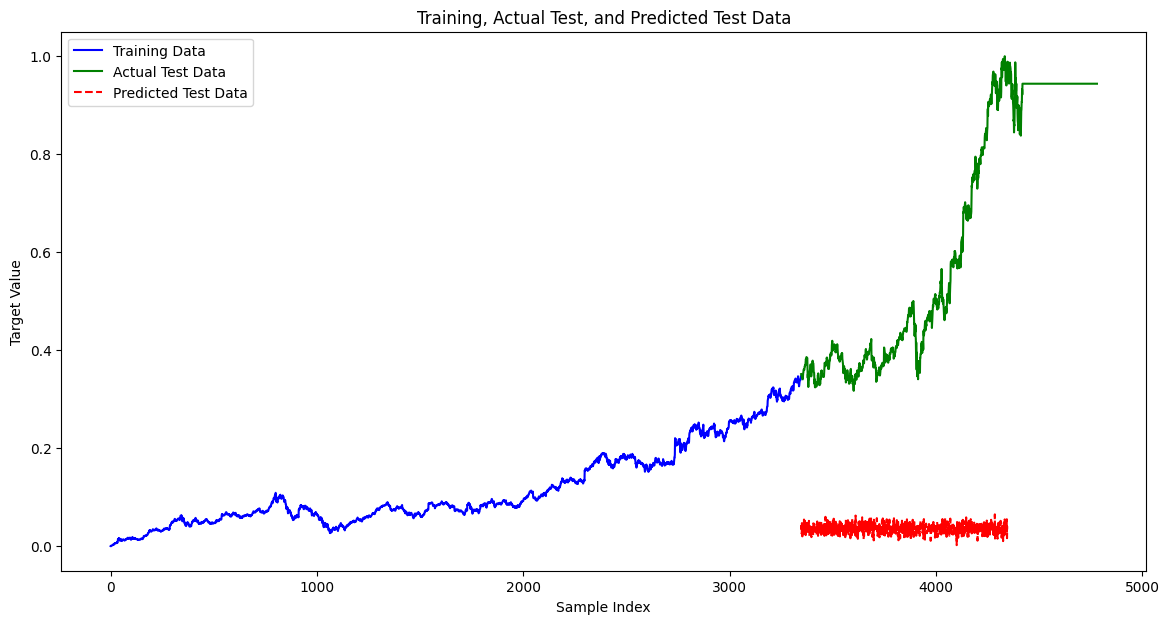

In [16]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(range(len(y_train)), y_train, label='Training Data', color='blue')

# Plot test data
test_data_start_index = len(y_train)
test_data_end_index = test_data_start_index + len(y_test)
plt.plot(range(test_data_start_index, test_data_end_index), y_test, label='Actual Test Data', color='green')

# Plot predicted data
predicted_data_start_index = test_data_start_index
predicted_data_end_index = predicted_data_start_index + len(y_pred)
plt.plot(range(predicted_data_start_index, predicted_data_end_index), y_pred, label='Predicted Test Data', color='red', linestyle='--')

plt.title('Training, Actual Test, and Predicted Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()